# 📈 Notebook 01 — S&P 500 Data Collection & Exploratory Data Analysis (EDA)

**Goal:**  
Load S&P 500 historical data, clean it, resample to monthly/quarterly, and conduct initial exploratory analysis to identify potential features for time-series modeling.

This notebook supports the FOMC Sentiment & S&P 500 Time-Series Analysis project.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

In [2]:
# Download S&P 500 index from FRED
sp500 = pdr.DataReader("SP500", "fred", start="2000-01-01", end="2025-01-01")

# Rename column to match our project convention
sp500 = sp500.rename(columns={"SP500": "sp500"})

sp500.head()

,sp500
DATE,
2015-12-02,2079.51
2015-12-03,2049.62
2015-12-04,2091.69
2015-12-07,2077.07
2015-12-08,2063.59


In [3]:
# Convert FRED's daily data to month-end frequency
sp500_m = sp500.resample("M").last()

# Show sample
sp500_m.head()

/var/folders/7_/j79tjdv53zb0k6zvj6gbbc8r0000gn/T/ipykernel_62148/2541374157.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_m = sp500.resample("M").last()


,sp500
DATE,
2015-12-31,2043.94
2016-01-31,1940.24
2016-02-29,1932.23
2016-03-31,2059.74
2016-04-30,2065.30


In [4]:
sp500.to_csv("../data/sp500_raw.csv")
print("Saved raw SP500 data to ../data/sp500_raw.csv")

Saved raw SP500 data to ../data/sp500_raw.csv


<Axes: title={'center': 'Monthly S&P 500 (FRED)'}, xlabel='DATE'>

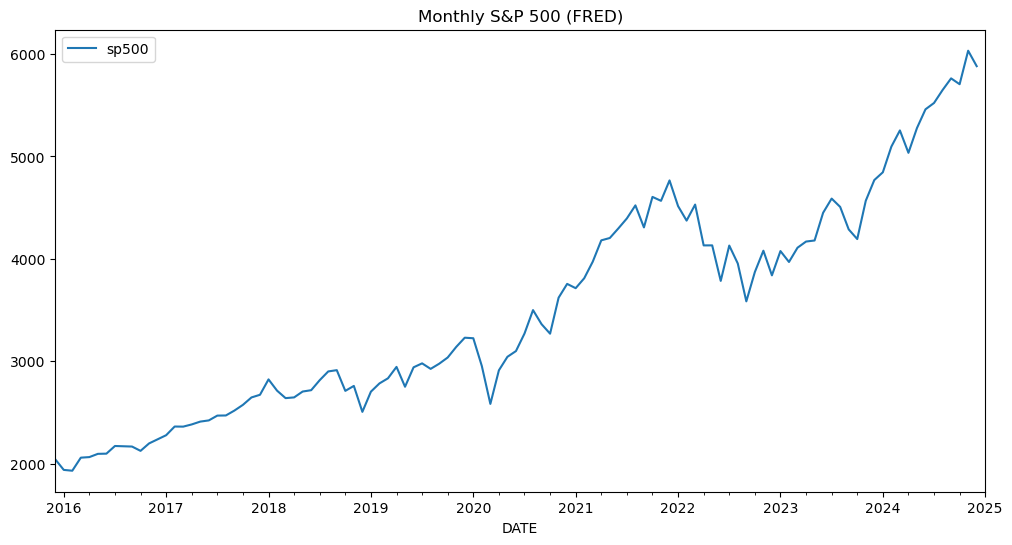

In [5]:
sp500_m.plot(figsize=(12,6), title="Monthly S&P 500 (FRED)")

### SP500 feature creation:
We engineered a comprehensive set of monthly S&P 500 features to support exploratory analysis and future predictive modeling. Core features include 1-month returns, next-month forward returns (our prediction target), and first differences, which capture short-term price behavior. We added rolling 3-month and 6-month volatility measures to quantify market risk leading into each period. To standardize comparisons across time, we computed z-scores for returns and volatility, allowing us to evaluate how extreme a given month is relative to long-run history. Finally, we categorized each monthly return into one of five regimes—high negative, negative, flat, positive, and high positive—and created one-hot indicator columns for each regime. These categories help simplify return dynamics into interpretable states, enabling easier visualization, descriptive statistics, and downstream modeling aligned with macroeconomic events such as FOMC meetings.


In [6]:
# Target: next month's return (shifted backward)
sp500_m["ret_1m"] = sp500_m["sp500"].pct_change()
sp500_m["ret_1m_next"] = sp500_m["ret_1m"].shift(-1)
sp500_m["firstdiff_1m"] = sp500_m["sp500"].diff()
sp500_m["vol_3m"] = sp500_m["ret_1m"].rolling(3).std()
sp500_m["vol_6m"] = sp500_m["ret_1m"].rolling(6).std()
sp500_m.head(12)

/var/folders/7_/j79tjdv53zb0k6zvj6gbbc8r0000gn/T/ipykernel_62148/1182639902.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp500_m["ret_1m"] = sp500_m["sp500"].pct_change()


,sp500,ret_1m,ret_1m_next,firstdiff_1m,vol_3m,vol_6m
DATE,,,,,,
2015-12-31,2043.94,NaN,-0.050735,NaN,NaN,NaN
2016-01-31,1940.24,-0.050735,-0.004128,-103.70,NaN,NaN
2016-02-29,1932.23,-0.004128,0.065991,-8.01,NaN,NaN
2016-03-31,2059.74,0.065991,0.002699,127.51,0.058757,NaN
2016-04-30,2065.30,0.002699,0.015329,5.56,0.038664,NaN
2016-05-31,2096.96,0.015329,0.000906,31.66,0.033496,NaN
2016-06-30,2098.86,0.000906,0.035610,1.90,0.007861,0.037519
2016-07-31,2173.60,0.035610,-0.001219,74.74,0.017434,0.026924
2016-08-31,2170.95,-0.001219,-0.001234,-2.65,0.020677,0.026438


In [7]:
# Helper function
def zscore(series):
    return (series - series.mean()) / series.std()

# Z-scores for returns
sp500_m["ret_1m_z"] = zscore(sp500_m["ret_1m"])
sp500_m["ret_1m_next_z"] = zscore(sp500_m["ret_1m_next"])

# Z-scores for volatility
sp500_m["vol_3m_z"] = zscore(sp500_m["vol_3m"])
sp500_m["vol_6m_z"] = zscore(sp500_m["vol_6m"])


One hot encoding returns categorization: possible prediction/regression targets

In [8]:
# ---- Return Categorization (One-Hot Encoding, aligned with ret_regime) ----

r = sp500_m["ret_1m"]

# thresholds based on volatility
ret_std = r.std()
flat_thr = 0.001        # ±0.1% is "flat"
strong_thr = ret_std    # 1 standard deviation move

# Initialize category columns to 0
for col in [
    "ret_high_negative",
    "ret_negative",
    "ret_flat",
    "ret_positive",
    "ret_high_positive"
]:
    sp500_m[col] = 0

# Assign categories with the SAME logic as ret_regime
sp500_m.loc[r < -strong_thr,                            "ret_high_negative"] = 1
sp500_m.loc[(r >= -strong_thr) & (r < -flat_thr),       "ret_negative"]       = 1
sp500_m.loc[(r >= -flat_thr) & (r <= flat_thr),         "ret_flat"]           = 1
sp500_m.loc[(r > flat_thr) & (r <= strong_thr),         "ret_positive"]       = 1
sp500_m.loc[r > strong_thr,                             "ret_high_positive"]  = 1


Same data being used for regression here instead of classification

In [9]:
r = sp500_m["ret_1m"]
ret_std = r.std()

flat_thr = 0.005          # ±0.1% is considered "flat"
strong_thr = ret_std      # 1 standard deviation move

sp500_m["ret_regime"] = np.select(
    condlist=[
        r < -strong_thr,                            # High Negative
        (r >= -strong_thr) & (r < -flat_thr),       # Negative
        (r >= -flat_thr) & (r <= flat_thr),         # Flat
        (r > flat_thr) & (r <= strong_thr),         # Positive
        r > strong_thr                              # High Positive
    ],
    choicelist=[-2, -1, 0, 1, 2],
    default=np.nan
)


In [10]:
# Sanity Check
category_cols = [
    "ret_high_negative",
    "ret_negative",
    "ret_flat",
    "ret_positive",
    "ret_high_positive"
]

# Sum the one-hot rows
sp500_m["category_sum"] = sp500_m[category_cols].sum(axis=1)

sp500_m["category_sum"].value_counts().head()


category_sum
1    109
0      1
Name: count, dtype: int64

In [11]:
sp500_m["ret_regime"].value_counts().sort_index()


ret_regime
-2.0    13
-1.0    16
 0.0    15
 1.0    45
 2.0    20
Name: count, dtype: int64

In [12]:
# ---- Export S&P 500 monthly features to data/ ----

output_path = "../data/sp500_features.csv"

sp500_m.to_csv(output_path, index=True)

output_path


'../data/sp500_features.csv'

### Why We Add GDP and Interest Rate Data  
To properly evaluate whether FOMC statement sentiment helps explain or predict S&P 500 returns, we need to control for broader macroeconomic conditions. Market movements are influenced not only by central bank communication, but also by fundamental drivers such as economic growth and monetary policy. By incorporating Real GDP (a proxy for economic activity) and the Federal Funds Rate (a direct measure of monetary policy stance), we can separate the effect of the FOMC statement itself from simultaneous macroeconomic changes. Including these variables ensures that any observed relationship between statement sentiment and market behavior is not simply reflecting underlying GDP trends or interest rate shifts, but instead captures the unique informational impact of the communication.


In [13]:

# ---- Download GDP (Quarterly) ----
gdp = pdr.DataReader("GDPC1", "fred", start="1990-01-01", end="2025-01-01")
gdp = gdp.rename(columns={"GDPC1": "gdp_real"})

# Convert quarterly GDP → monthly (forward-fill is standard)
gdp = gdp.resample("M").ffill()

print(gdp.head())

# ---- Fed Funds Rate ----
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start="1990-01-01", end="2025-01-01")
fedfunds = fedfunds.rename(columns={"FEDFUNDS": "fed_funds_rate"})

print(fedfunds.head())


/var/folders/7_/j79tjdv53zb0k6zvj6gbbc8r0000gn/T/ipykernel_62148/2877837560.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gdp = gdp.resample("M").ffill()


             gdp_real
DATE                 
1990-01-31  10047.386
1990-02-28  10047.386
1990-03-31  10047.386
1990-04-30  10083.855
1990-05-31  10083.855
            fed_funds_rate
DATE                      
1990-01-01            8.23
1990-02-01            8.24
1990-03-01            8.28
1990-04-01            8.26
1990-05-01            8.18


In [14]:
gdp["gdp_mom"] = gdp["gdp_real"].pct_change()
fedfunds["ff_mom"] = fedfunds["fed_funds_rate"].diff()
fedfunds["ff_mom_pct"] = fedfunds["fed_funds_rate"].pct_change()

Initial EDA

In [15]:
# ---- Merge macro data into sp500_m ----

sp500_macro = (
    sp500_m
    .merge(gdp[["gdp_real", "gdp_mom"]], left_index=True, right_index=True, how="left")
    .merge(fedfunds[["fed_funds_rate", "ff_mom", "ff_mom_pct"]], left_index=True, right_index=True, how="left")
)

sp500_macro.head()


,sp500,ret_1m,ret_1m_next,firstdiff_1m,vol_3m,vol_6m,ret_1m_z,ret_1m_next_z,vol_3m_z,vol_6m_z,...,ret_flat,ret_positive,ret_high_positive,ret_regime,category_sum,gdp_real,gdp_mom,fed_funds_rate,ff_mom,ff_mom_pct
DATE,,,,,,,,,,,,,,,,,,,,,
2015-12-31,2043.94,NaN,-0.050735,NaN,NaN,NaN,NaN,-1.377293,NaN,NaN,...,0,0,0,NaN,0,18892.206,0.000000,NaN,NaN,NaN
2016-01-31,1940.24,-0.050735,-0.004128,-103.70,NaN,NaN,-1.377293,-0.333054,NaN,NaN,...,0,0,0,-2.0,1,19001.690,0.005795,NaN,NaN,NaN
2016-02-29,1932.23,-0.004128,0.065991,-8.01,NaN,NaN,-0.333054,1.237986,NaN,NaN,...,0,0,0,0.0,1,19001.690,0.000000,NaN,NaN,NaN
2016-03-31,2059.74,0.065991,0.002699,127.51,0.058757,NaN,1.237986,-0.180078,0.708588,NaN,...,0,0,1,2.0,1,19001.690,0.000000,NaN,NaN,NaN
2016-04-30,2065.30,0.002699,0.015329,5.56,0.038664,NaN,-0.180078,0.102903,-0.022403,NaN,...,0,1,0,0.0,1,19062.709,0.003211,NaN,NaN,NaN


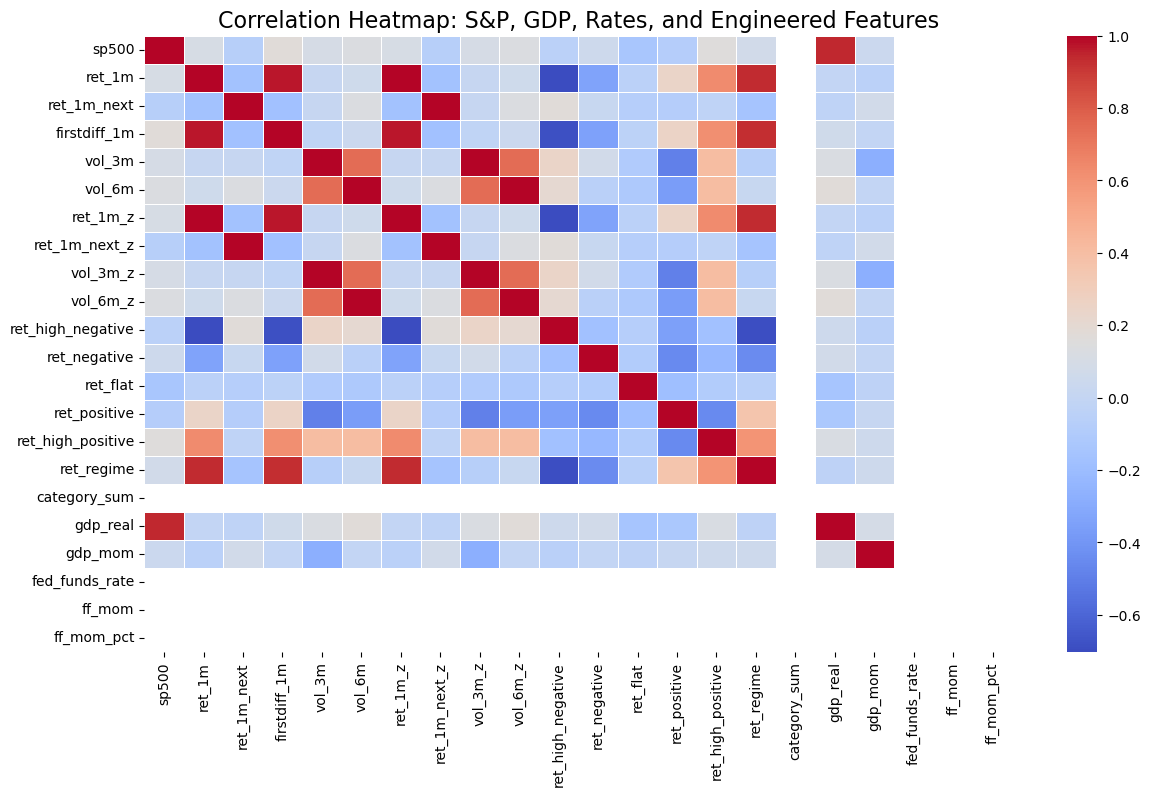

In [16]:
sp500_macro = sp500_macro.dropna(subset=["ret_1m", "ret_1m_next"])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
sns.heatmap(
    sp500_macro.corr(),
    cmap="coolwarm",
    annot=False,
    linewidths=0.5
)

plt.title("Correlation Heatmap: S&P, GDP, Rates, and Engineered Features", fontsize=16)
plt.show()


In [17]:
def to_month_end(df):
    out = df.copy()
    out.index = out.index.to_period("M").to_timestamp("M")  # e.g., 1990-01 → 1990-01-31
    return out

In [18]:
# Ensure all three are keyed by the same month-end dates
sp500_m_me   = to_month_end(sp500_m)
gdp_me       = to_month_end(gdp)        # gdp already resampled("M"), this just normalizes index
fedfunds_me  = to_month_end(fedfunds)   # converts 1990-01-01 → 1990-01-31, etc.


In [19]:
gdp_me

,gdp_real,gdp_mom
DATE,,
1990-01-31,10047.386,NaN
1990-02-28,10047.386,0.000000
1990-03-31,10047.386,0.000000
1990-04-30,10083.855,0.003630
1990-05-31,10083.855,0.000000
...,...,...
2024-09-30,23478.570,0.000000
2024-10-31,23586.542,0.004599
2024-11-30,23586.542,0.000000


In [20]:
sp500_macro = (
    sp500_m_me
    .merge(gdp_me[["gdp_real", "gdp_mom", "gdp_mom"]], 
           left_index=True, right_index=True, how="left")
    .merge(fedfunds_me[["fed_funds_rate", "ff_mom", "ff_mom_pct"]],
           left_index=True, right_index=True, how="left")
)

# Drop rows where we don't have returns
sp500_macro = sp500_macro.dropna(subset=["ret_1m_next"])
sp500_macro.head()


,sp500,ret_1m,ret_1m_next,firstdiff_1m,vol_3m,vol_6m,ret_1m_z,ret_1m_next_z,vol_3m_z,vol_6m_z,...,ret_positive,ret_high_positive,ret_regime,category_sum,gdp_real,gdp_mom,gdp_mom,fed_funds_rate,ff_mom,ff_mom_pct
DATE,,,,,,,,,,,,,,,,,,,,,
2015-12-31,2043.94,NaN,-0.050735,NaN,NaN,NaN,NaN,-1.377293,NaN,NaN,...,0,0,NaN,0,18892.206,0.000000,0.000000,0.24,0.12,1.000000
2016-01-31,1940.24,-0.050735,-0.004128,-103.70,NaN,NaN,-1.377293,-0.333054,NaN,NaN,...,0,0,-2.0,1,19001.690,0.005795,0.005795,0.34,0.10,0.416667
2016-02-29,1932.23,-0.004128,0.065991,-8.01,NaN,NaN,-0.333054,1.237986,NaN,NaN,...,0,0,0.0,1,19001.690,0.000000,0.000000,0.38,0.04,0.117647
2016-03-31,2059.74,0.065991,0.002699,127.51,0.058757,NaN,1.237986,-0.180078,0.708588,NaN,...,0,1,2.0,1,19001.690,0.000000,0.000000,0.36,-0.02,-0.052632
2016-04-30,2065.30,0.002699,0.015329,5.56,0.038664,NaN,-0.180078,0.102903,-0.022403,NaN,...,1,0,0.0,1,19062.709,0.003211,0.003211,0.37,0.01,0.027778


Type of gdp_raw: <class 'pandas.core.frame.DataFrame'>
Type of ret_raw: <class 'pandas.core.series.Series'>
gdp_mom has duplicate columns; taking the first one.
After fixing duplicates:
gdp_raw shape: (109,)
ret_raw shape: (109,)
gdp_ret shape: (109, 2)
gdp_mom        float64
ret_1m_next    float64
dtype: object
    gdp_mom  ret_1m_next
0  0.000000    -0.050735
1  0.005795    -0.004128
2  0.000000     0.065991
3  0.000000     0.002699
4  0.003211     0.015329


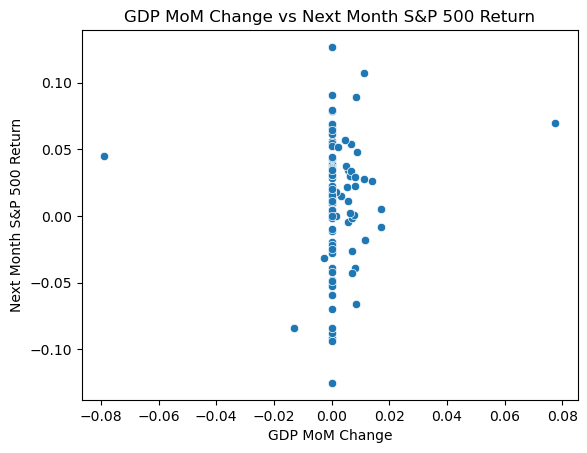

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Get the raw columns (may be Series OR DataFrame)
# ------------------------------------------------
gdp_raw = sp500_macro["gdp_mom"]
ret_raw = sp500_macro["ret_1m_next"]

print("Type of gdp_raw:", type(gdp_raw))
print("Type of ret_raw:", type(ret_raw))

# If there are duplicate column names, pandas returns a DataFrame for df["col"]
# In that case, take the first of the duplicate columns.
if isinstance(gdp_raw, pd.DataFrame):
    print("gdp_mom has duplicate columns; taking the first one.")
    gdp_raw = gdp_raw.iloc[:, 0]

if isinstance(ret_raw, pd.DataFrame):
    print("ret_1m_next has duplicate columns; taking the first one.")
    ret_raw = ret_raw.iloc[:, 0]

print("After fixing duplicates:")
print("gdp_raw shape:", np.array(gdp_raw.values).shape)
print("ret_raw shape:", np.array(ret_raw.values).shape)

# ------------------------------------------------
# 2. Helper to flatten any list/array values in the Series
# ------------------------------------------------
def series_to_scalar_numeric(s):
    """
    Ensure each element of s is a scalar:
    - If element is list/tuple/ndarray, take the first entry.
    - Otherwise, keep as-is.
    Then convert to numeric.
    """
    cleaned = []
    for v in s:
        if isinstance(v, (list, tuple, np.ndarray)):
            cleaned.append(v[0])
        else:
            cleaned.append(v)
    return pd.to_numeric(cleaned, errors="coerce")

gdp_clean = series_to_scalar_numeric(gdp_raw)
ret_clean = series_to_scalar_numeric(ret_raw)

# ------------------------------------------------
# 3. Build final clean DataFrame and drop NaNs
# ------------------------------------------------
gdp_ret = pd.DataFrame({
    "gdp_mom": gdp_clean,
    "ret_1m_next": ret_clean
}).dropna()

print("gdp_ret shape:", gdp_ret.shape)
print(gdp_ret.dtypes)
print(gdp_ret.head())

# ------------------------------------------------
# 4. Plot
# ------------------------------------------------
sns.scatterplot(data=gdp_ret, x="gdp_mom", y="ret_1m_next")
plt.title("GDP MoM Change vs Next Month S&P 500 Return")
plt.xlabel("GDP MoM Change")
plt.ylabel("Next Month S&P 500 Return")
plt.show()


### Regression Analysis:

In [23]:
sp500_macro.columns


Index(['sp500', 'ret_1m', 'ret_1m_next', 'firstdiff_1m', 'vol_3m', 'vol_6m',
       'ret_1m_z', 'ret_1m_next_z', 'vol_3m_z', 'vol_6m_z',
       'ret_high_negative', 'ret_negative', 'ret_flat', 'ret_positive',
       'ret_high_positive', 'ret_regime', 'category_sum', 'gdp_real',
       'gdp_mom', 'gdp_mom', 'fed_funds_rate', 'ff_mom', 'ff_mom_pct'],
      dtype='object')

In [24]:
# ---- Build regression dataset using existing columns ----
reg_df = sp500_macro[[
    "ret_1m_next",      # target
    "ret_1m",           # this month's return
    "ret_1m_z",         # z-score of this month's return
    "vol_3m_z",         # z-score of 3-month volatility
    # "vol_6m_z",       # optional: you can include this too if you want
    "gdp_mom",    # GDP change (only real release months)
    "fed_funds_rate",   # level of policy rate
    "ff_mom",           # 1-month change in policy rate
    "ff_mom_pct"        # % change in policy rate
]].dropna()

reg_df.head()


,ret_1m_next,ret_1m,ret_1m_z,vol_3m_z,gdp_mom,gdp_mom,fed_funds_rate,ff_mom,ff_mom_pct
DATE,,,,,,,,,
2016-03-31,0.002699,0.065991,1.237986,0.708588,0.000000,0.000000,0.36,-0.02,-0.052632
2016-04-30,0.015329,0.002699,-0.180078,-0.022403,0.003211,0.003211,0.37,0.01,0.027778
2016-05-31,0.000906,0.015329,0.102903,-0.210391,0.000000,0.000000,0.37,0.00,0.000000
2016-06-30,0.035610,0.000906,-0.220257,-1.143005,0.000000,0.000000,0.38,0.01,0.027027
2016-07-31,-0.001219,0.035610,0.557287,-0.794736,0.007094,0.007094,0.39,0.01,0.026316


Macro indicators alone do not reliably explain next-month S&P returns

In [26]:
import statsmodels.api as sm

X1 = reg_df[["gdp_mom", "fed_funds_rate", "ff_mom", "ff_mom_pct"]]
y  = reg_df["ret_1m_next"]

X1_const = sm.add_constant(X1)
model1 = sm.OLS(y, X1_const).fit()
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:            ret_1m_next   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     3.814
Date:                Tue, 02 Dec 2025   Prob (F-statistic):            0.00627
Time:                        12:37:43   Log-Likelihood:                 187.41
No. Observations:                 106   AIC:                            -364.8
Df Residuals:                     101   BIC:                            -351.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0126      0.006      2.

market+macro features

In [27]:
X2 = reg_df[[
    "ret_1m",
    "ret_1m_z",
    "vol_3m_z",
    "gdp_mom",
    "fed_funds_rate",
    "ff_mom",
    "ff_mom_pct"
]]

y = reg_df["ret_1m_next"]

X2_const = sm.add_constant(X2)
model2 = sm.OLS(y, X2_const).fit()
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:            ret_1m_next   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     3.474
Date:                Tue, 02 Dec 2025   Prob (F-statistic):            0.00370
Time:                        12:37:46   Log-Likelihood:                 190.08
No. Observations:                 106   AIC:                            -366.2
Df Residuals:                      99   BIC:                            -347.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0127      0.006      2.

Analyzing 2025 data

In [30]:
import os

# Move up one folder
os.chdir("..")

print("Now in:", os.getcwd())
print("Folders here:", os.listdir())


Now in: /Users/jacobbanov/FOMC-statement-S-P-500-time-series-analysis
Folders here: ['.Rhistory', '.DS_Store', 'sp500_monthly.csv', 'requirements.txt', 'README.md', '.git', 'data', 'outputs', 'notebooks', 'src']


In [38]:
import os
os.chdir("FOMC-statement-S-P-500-time-series-analysis")
print(os.getcwd())
print(os.listdir())


/Users/jacobbanov/FOMC-statement-S-P-500-time-series-analysis
['.Rhistory', '.DS_Store', 'sp500_monthly.csv', 'requirements.txt', 'README.md', '.git', 'data', 'outputs', 'notebooks', 'src']


In [39]:
os.chdir("data")

In [40]:
print("Now in:", os.getcwd())
print("Folders here:", os.listdir())

Now in: /Users/jacobbanov/FOMC-statement-S-P-500-time-series-analysis/data
Folders here: ['sp500_raw.csv', 'sp500_features.csv', '2025_sp500_monthly.csv', 'all_fed_paragraphs_v2.csv', 'fed_sentiment_results.csv']


In [41]:
import pandas as pd
import numpy as np

# -------------------------------
# 1. Load 2025 S&P500 data
# -------------------------------
df = pd.read_csv("2025_sp500_monthly.csv")

# Fix column names based on your dataset
df = df.rename(columns={
    "observation_date": "Date",
    "SP500": "Close"
})

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# -------------------------------
# 2. Compute daily returns
# -------------------------------
df['return'] = df['Close'].pct_change()

# -------------------------------
# 3. Bucket function
# (same structure as your training labels)
# -------------------------------
def bucketize(r):
    if pd.isna(r):
        return np.nan
    if r > 0.01:
        return 2
    elif r > 0.0:
        return 1
    elif r == 0:
        return 0
    elif r > -0.01:
        return -1
    else:
        return -2

df['bucket'] = df['return'].apply(bucketize)

# -------------------------------
# 4. One-hot encoding of buckets (-2,-1,0,1,2)
# -------------------------------
one_hot = pd.get_dummies(df['bucket'], prefix="bucket")
df = pd.concat([df, one_hot], axis=1)

# -------------------------------
# 5. Binary up/down label (0 or 1)
# -------------------------------
df['up_binary'] = (df['return'] > 0).astype(int)

# -------------------------------
# 6. Save the output
# -------------------------------
df.to_csv("sp500_2025_buckets_and_onehot.csv", index=False)

df.tail()


,Date,Close,return,bucket,bucket_-2.0,bucket_-1.0,bucket_1.0,bucket_2.0,up_binary
56,2025-08-31,6460.26,0.019067,2.0,False,False,False,True,1
57,2025-09-30,6688.46,0.035324,2.0,False,False,False,True,1
58,2025-10-31,6840.20,0.022687,2.0,False,False,False,True,1
59,2025-11-30,6849.09,0.001300,1.0,False,False,True,False,1
60,2025-12-31,6812.63,-0.005323,-1.0,False,True,False,False,0
